<a href="https://colab.research.google.com/github/1900690/fisheye-distortion-correction/blob/main/3_undistort_fisheye_stereo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# undistort_fisheye_stereo
魚眼カメラモデルを使用してステレオカメラキャリブレーション、視差画像推定、三次元復元を行うNotebookです。`undistort_fisheye.ipynb`では片方ずつのカメラ画像を処理していましたが、今回は左右両方のカメラ画像からステレオカメラの向きや位置関係を推定します。後半では推定したカメラの位置関係と画像をもとに物体とカメラの距離を推定します。

## キャリブレーション手順
1. 事前に`undistort/undistort_data_collection.ipynb`を実行しキャリブレーション用画像を撮影します
1. `undistort/chess_images_stereo`ディレクトリに撮影したキャリブレーション画像があることを確認します
1. セルを順に実行し視差画像が作成されれば完了です

* 参考:
    * [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html)

## カメラキャリブレーション
下記に続くセルを順に実行していきます。まずは必要なPythonモジュールを読み込みます。

In [ ]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import yaml

PyYAMLのバージョンを確認します。3.14以上が必要だと言うメッセージが出た場合はコメントアウトしてある`!pip install PyYAML`の行を実行してください。

In [ ]:
#!pip install PyYAML==5.4.1
if yaml.__version__ < '3.14':
    print("PyYAML 3.14以上が必要です")
else:
    print("PyYAML OK")

キャリブレーション用画像を読み込みます。セルを実行すると画像のファイルパスが一覧になって表示されることをご確認ください。

In [ ]:
imgs_dir_l = sorted(glob.glob(os.path.join('chess_images_stereo', '*left*.jpg')))
imgs_dir_r = sorted(glob.glob(os.path.join('chess_images_stereo', '*right*.jpg')))

print(imgs_dir_l)
print(imgs_dir_r)

['chess_images_stereo/326b47e2-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/3b0da6d8-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/427dad0a-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/4554d9f4-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/47d3933c-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/4a22d03a-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/4e3a0d00-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/4fd662d0-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/6e016e94-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/75c66224-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/7bed500e-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/829f2b8e-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/84d572b4-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/8670ed42-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/883ebe06-b94

チェスボードの角(格子点)の数とマスの辺の長さを`camera_config.xml`から読み込みます。

In [ ]:
tree = ET.parse("../camera_param/camera_config.xml")
root = tree.getroot()
v_num = int(root.find("board_param").find("v_num").text) # 横方向の格子点数
h_num = int(root.find("board_param").find("h_num").text) # 縦方向の格子点数
chess_size = float(root.find("board_param").find("chess_size").text) # チェスボード１マスあたりの長さ[mm]

キャリブレーションに必要なobject pointsを作成します。object poiintsはワールド座標系におけるチェスボードの格子点の位置です。撮影対象の奥行きを計測する際に画像と現実の縮尺情報が必要になるのでobject pointsにチェスボードのマスの大きさが反映されています。

In [ ]:
object_point = np.zeros((v_num*h_num, 1, 3), np.float32) # fisheye.calibrate()用に次元を追加
object_point[:, 0, :2] = np.mgrid[0:v_num, 0:h_num].T.reshape(-1,2) * chess_size # マスの大きさを反映

object_points = [] # 上述したobject_pointの集まり（3次元ベクトルのリスト）
img_points_l = [] # 左カメラの画像座標上での格子点（2次元空間）の集まり（2次元ベクトルのリスト）
img_points_r = [] # 右カメラの画像座標上での格子点（2次元空間）の集まり（2次元ベクトルのリスト）

次のステップでチェスボードの格子点を検出するので、検出結果をわかりやすく描画するための関数を作成しておきます。

In [ ]:
def reserveCorners(img, corners, img_points, imgs):
    corners_subpix = cv2.cornerSubPix(img, corners, (3, 3), (-1, -1), criteria)
    img_points.append(corners_subpix)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    imgs.append(cv2.drawChessboardCorners(img, (v_num, h_num), corners_subpix, True))

各キャリブレーション用画像からチェスボードの格子点を検出し、`img_points`に保存します。`img_points`の位置関係からカメラの歪み具合が推定できます。`img_points`が二次元画像上の格子点の位置を保存し、`object_points`が三次元空間上の格子点の位置を保存しています。

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # 反復アルゴリズムの終了基準の指定
imgs_l = [] # 左カメラの画像表示用
imgs_r = [] # 右カメラの画像表示用

for img_dir_l, img_dir_r in zip(imgs_dir_l, imgs_dir_r):
    img_l = cv2.imread(img_dir_l, cv2.IMREAD_GRAYSCALE)
    img_r = cv2.imread(img_dir_r, cv2.IMREAD_GRAYSCALE)
    ret_l, corners_l = cv2.findChessboardCorners(img_l, (v_num, h_num), None) # 左カメラ画像から格子点を探す（ピクセル単位）
    ret_r, corners_r = cv2.findChessboardCorners(img_r, (v_num, h_num), None) # 右カメラ画像から格子点を探す（ピクセル単位）
    if ret_l == True and ret_r == True: # 左右両方の画像から検出に成功した場合のみ、その結果を保存する
        object_points.append(object_point)
        reserveCorners(img_l, corners_l, img_points_l, imgs_l)
        reserveCorners(img_r, corners_r, img_points_r, imgs_r)

チェスボードの格子点が正しく検出されているか確認するため、検出結果を表示する関数を作成します。

In [ ]:
def gridShow(imgs):
    img_num = len(imgs)
    col = 3
    row = np.ceil(img_num / col)

    fig = plt.figure(figsize=(18, 4*row))
    for i, img in enumerate(imgs):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis = fig.add_subplot(row, col, i+1)
        axis.imshow(img)
        i += 1

チェスボードの格子点の検出結果を表示します。格子点が色のついた線で結ばれていれば正常に検出されています。

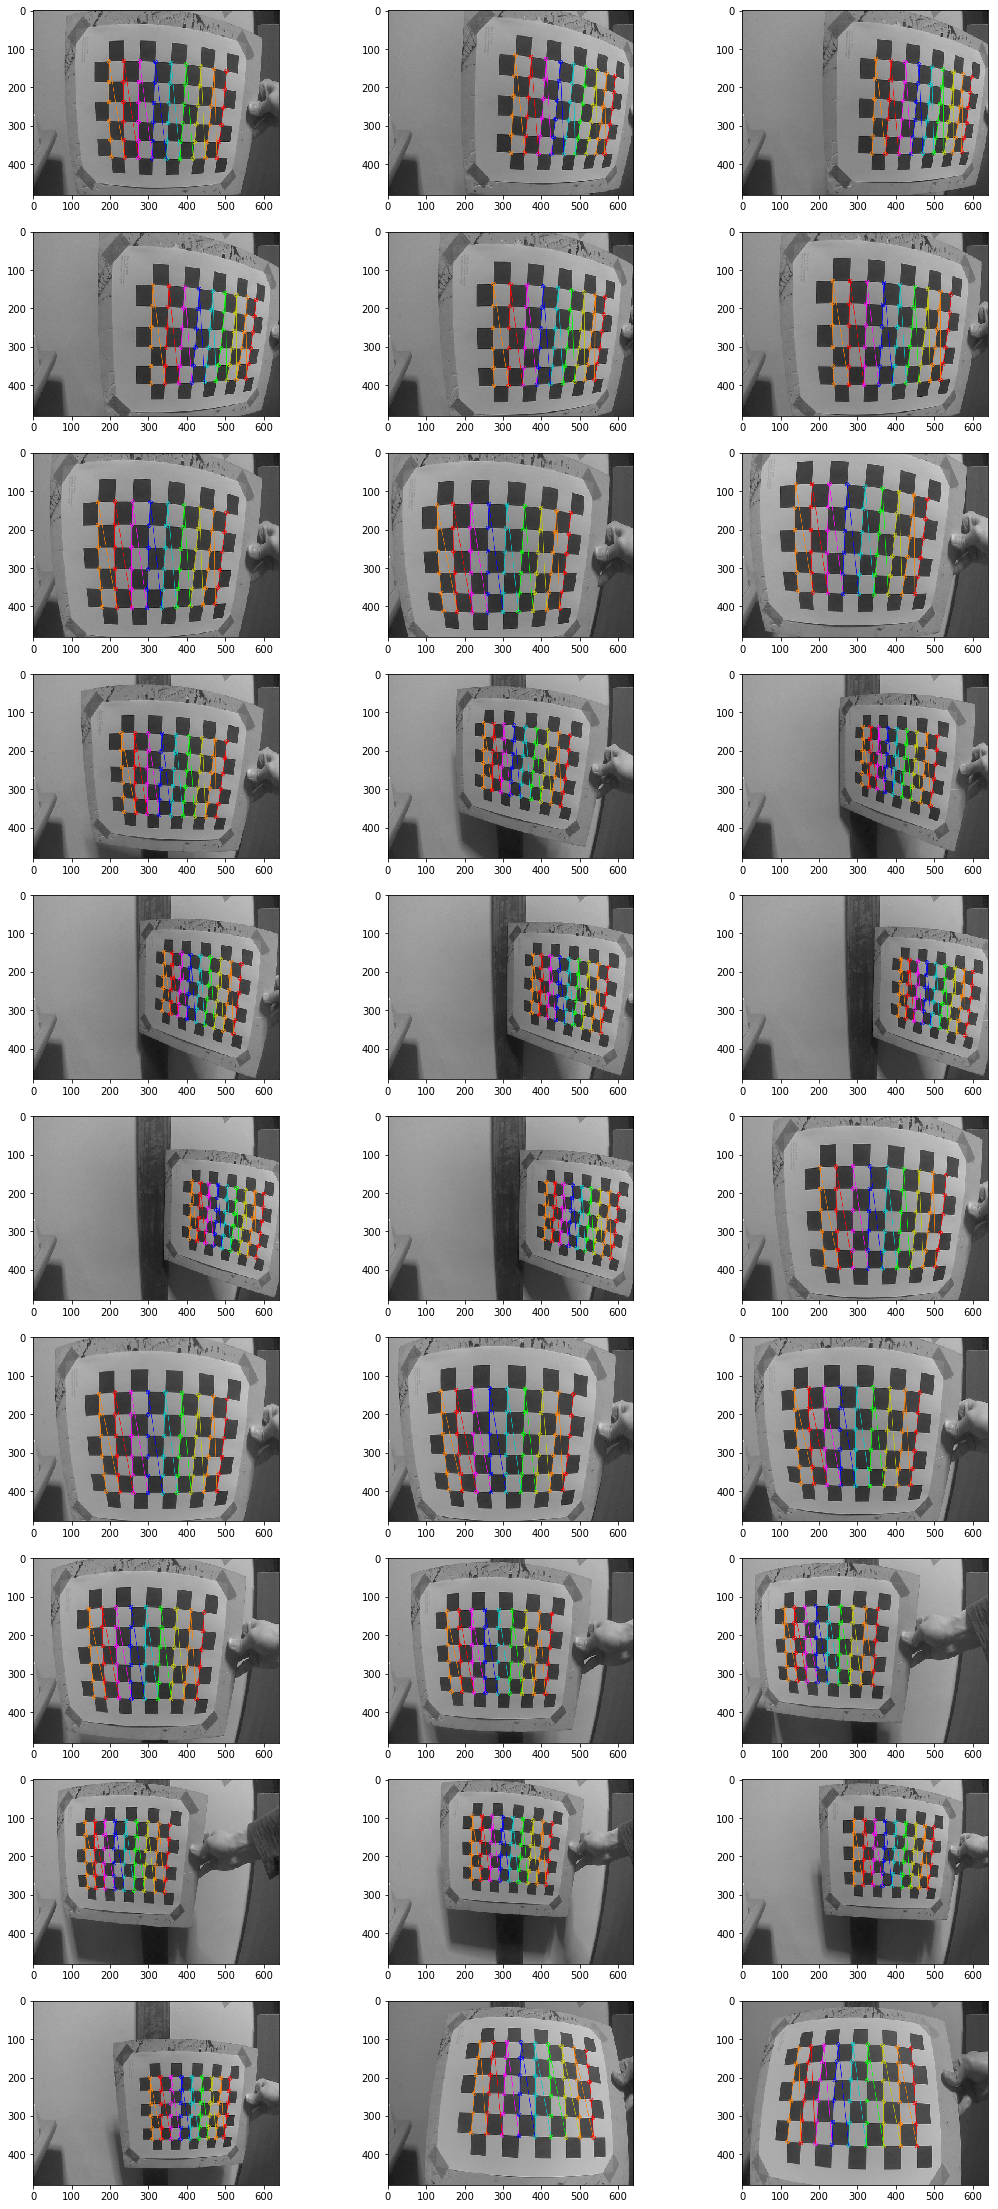

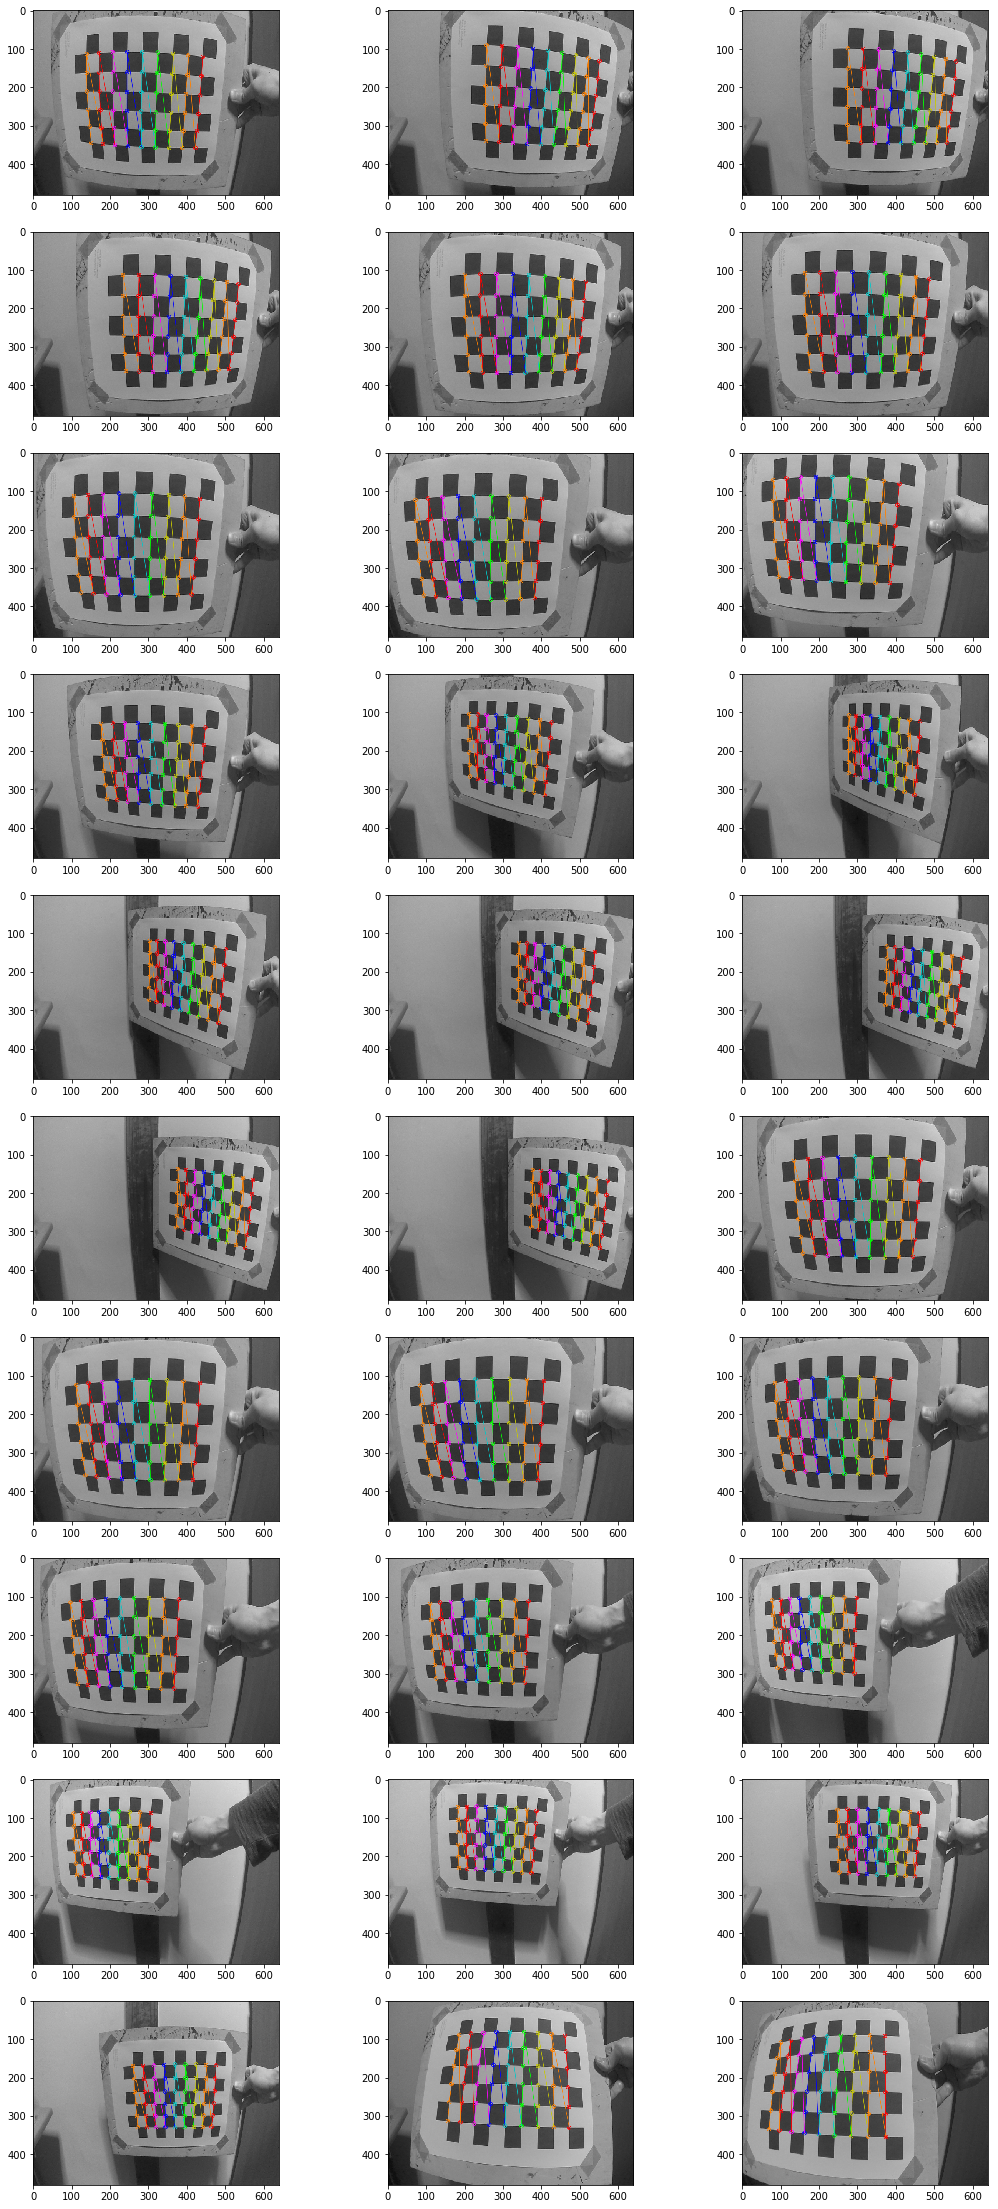

In [ ]:
gridShow(imgs_l)
gridShow(imgs_r)

`undistort/undistort_fisheye.ipynb`で作成したカメラパラメータを読み込み、ステレオカメラキャリブレーションの初期値に用います。

In [ ]:
camera_param_l = np.load("../camera_param/camera_param_fisheye_l.npz")
camera_param_r = np.load("../camera_param/camera_param_fisheye_r.npz")
mtx_l, dist_l = [camera_param_l[i] for i in ["mtx_l", "dist_l"]]
mtx_r, dist_r = [camera_param_r[i] for i in ["mtx_r", "dist_r"]]

キャリブレーション用画像からカメラモデルを推定します。このカメラモデルにカメラの歪み具合などの情報が含まれており、歪み補正に使用します。ステレオカメラの場合は左右のカメラの位置関係も同時に推定します。
* カメラモデルのパラメータ(`_l`が末尾につくものは左カメラ、`_r`は右カメラです)
    * `mtx`: カメラの内部パラメータ行列
    * `dist`: 歪み係数のベクトル(ここではk_1, k_2, p_1, p_2)
    * `R`: カメラ座標系間の回転行列
    * `T`: カメラ座標系間の並進ベクトル

In [ ]:
h, w = img_l.shape[:2]

_, mtx_l, dist_l, mtx_r, dist_r, R, T = \
    cv2.fisheye.stereoCalibrate(
        object_points,
        img_points_l,
        img_points_r,
        mtx_l,
        dist_l,
        mtx_r,
        dist_r,
        (w,h)
    )

作成したステレオカメラモデルを保存します。

In [ ]:
np.savez('../camera_param/camera_param_fisheye.npz',
    mtx_l=mtx_l,
    dist_l=dist_l,
    mtx_r=mtx_r,
    dist_r=dist_r,
    R=R,
    T=T
)

歪みを補正したカメラモデルを作成し、画像の歪み補正を行います。左が補正前、右が補正後です。チェスボードのマス目がまっすぐになっていれば正常に歪み補正がされています。

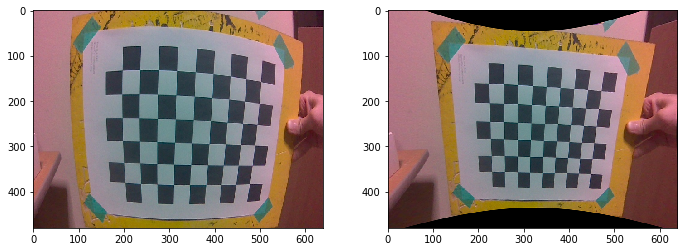

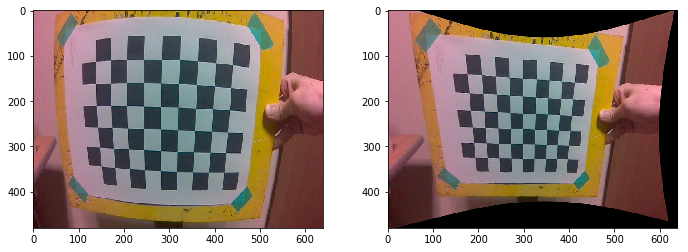

In [ ]:
img_l = cv2.imread(imgs_dir_l[0])
img_r = cv2.imread(imgs_dir_r[0])

newmtx_l = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(mtx_l, dist_l, (w,h), None, balance=1.0)
map1, map2 = cv2.fisheye.initUndistortRectifyMap(mtx_l, dist_l, None, newmtx_l, (w, h), cv2.CV_16SC2)
undistorted_img_l = cv2.remap(img_l, map1, map2, cv2.INTER_CUBIC, cv2.BORDER_CONSTANT)

newmtx_r = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(mtx_r, dist_r, (w,h), None, balance=1.0)
map1, map2 = cv2.fisheye.initUndistortRectifyMap(mtx_r, dist_r, None, newmtx_r, (w, h), cv2.CV_16SC2)
undistorted_img_r = cv2.remap(img_r, map1, map2, cv2.INTER_CUBIC, cv2.BORDER_CONSTANT)

gridShow([img_l, undistorted_img_l])
gridShow([img_r, undistorted_img_r])

## 視差画像作成
ステレオ画像を用いて視差を計算します。

3次元復元の前段階として視差画像を作成します。ここで言う視差とは3次元空間上でのある1点（例えば顔の位置）が左右の画像でどれだけズレたかを意味します。視差が小さい箇所は遠くに、視差が大きい箇所は近くにあると言うことがわかります。

次のステップでエピポーラ線を求めるため、求めた線をわかりやすく描画するための関数を作成します。

In [ ]:
def drawEpipolarLine(img):
    i = 0
    h, w = img.shape[:2]
    for i in range(10):
        y = h*i//10
        epipolar_img = cv2.line(img, (0, y), (w, y), (0, 0, 255), 2)
    return epipolar_img

視差画像を推定するためにステレオ平行化を行います。ステレオ平行化は簡単に説明すると左右の画像の高さをそろえることです。

まずはステレオ平行化に必要なパラメータを取得します。
* `Rp`: ステレオ平行化のために修正されたカメラ座標から見た元のカメラ座標の姿勢
* `Pp`: 修正されたカメラ座標系から画像座標系への射影変換行列
* `Q`: 視差画像を深度画像へマッピングするための行列

In [ ]:
Rp_l, Rp_r, Pp_l, Pp_r, Q = \
    cv2.fisheye.stereoRectify(
        newmtx_l, dist_l, newmtx_r, dist_r, (w,h), R, T, 0
    )

次にステレオ平行化と歪み補正を行います。左右の画像で被写体の高さが合っているか確認してください。エピポーラ線(横向きの赤い線)を目印に見比べるとわかりやすいです。

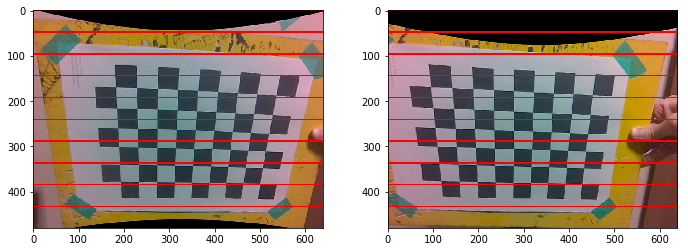

In [ ]:
map1, map2 = cv2.fisheye.initUndistortRectifyMap(mtx_l, dist_l, Rp_l, Pp_l, (w, h), cv2.CV_16SC2)
rectified_img_l = cv2.remap(img_l, map1, map2, cv2.INTER_CUBIC, cv2.BORDER_CONSTANT)

map1, map2 = cv2.fisheye.initUndistortRectifyMap(mtx_r, dist_r, Rp_r, Pp_r, (w, h), cv2.CV_16SC2)
rectified_img_r = cv2.remap(img_r, map1, map2, cv2.INTER_CUBIC, cv2.BORDER_CONSTANT)

epipolar_img_l = drawEpipolarLine(rectified_img_l)
epipolar_img_r = drawEpipolarLine(rectified_img_r)

gridShow([epipolar_img_l, epipolar_img_r])

### Block Matchingによる視差画像作成

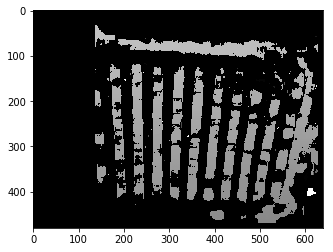

In [ ]:
window_size = 21 # 大きめに設定する
num_disp = 128 # 最大視差
stereo = cv2.StereoBM_create(num_disp, window_size)

rectified_grayimg_l = cv2.cvtColor(rectified_img_l, cv2.COLOR_BGR2GRAY)
rectified_grayimg_r = cv2.cvtColor(rectified_img_r, cv2.COLOR_BGR2GRAY)

disparity = stereo.compute(rectified_grayimg_l, rectified_grayimg_r)
plt.imshow(disparity, cmap='gray')

### Semi-Global Block Matchingによる視差画像作成

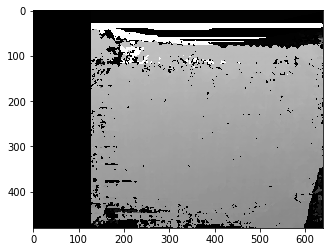

In [ ]:
min_disp = 0
window_size = 5
stereo = cv2.StereoSGBM_create(
    minDisparity = min_disp,
    numDisparities = 128,
    blockSize = window_size,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 5,
    speckleWindowSize = 100,
    speckleRange = 32
)

rectified_grayimg_l = cv2.cvtColor(rectified_img_l, cv2.COLOR_BGR2GRAY)
rectified_grayimg_r = cv2.cvtColor(rectified_img_r, cv2.COLOR_BGR2GRAY)

disparity = stereo.compute(rectified_grayimg_l, rectified_grayimg_r) / 16
plt.imshow(disparity, cmap='gray')

## OpanVSLAM用パラメータ作成
[jnmouse_ros_examples](https://github.com/rt-net/jnmouse_ros_examples)にて公開しているOpenVSLAMのサンプルを実行する際必要になるコンフィグファイルを作成します。サンプルを実行する場合は作成した`../camera_param/`にある`jnmouse_stereo.yaml`を`jnmouse_ros_examples/config`内の`jnmouse_stereo.yaml`と置き換えてください。サンプルの実行手順は`jnmouse_ros_examples`のREADMEをご覧ください。

In [ ]:
vslam_param = {
    'Camera':{
        'name': 'jnmouse stereo',
        'setup': 'stereo',
        'model': 'fisheye',
        'fx': float(Pp_l[0][0]),
        'fy': float(Pp_l[1][1]),
        'cx': float(Pp_l[0][2]),
        'cy': float(Pp_l[1][2]),
        'k1': 0.0,
        'k2': 0.0,
        'k3': 0.0,
        'k4': 0.0,
        'fps': 30.0,
        'cols': 640,
        'rows': 480,
        'focal_x_baseline': float(-Pp_r[0][3]/1000),
        'color_order': 'RGB'
    },
    'StereoRectifier':{
       'K_left': mtx_l.flatten().tolist(),
       'D_left': dist_l.flatten().tolist(),
       'R_left': Rp_l.flatten().tolist(),
       'K_right': mtx_r.flatten().tolist(),
       'D_right': dist_r.flatten().tolist(),
       'R_right': Rp_r.flatten().tolist()
    },
    'Feature':{
        'max_num_keypoints': 2000,
        'scale_factor': 1.2,
        'num_levels': 8,
        'ini_fast_threshold': 20,
        'min_fast_threshold': 7,
    },
    'Initializer':{ },
    'Mapping':{
        'baseline_dist_thr': 0.02
    },
    'SocketPublisher':{
        'image_quality': 5,
        'publish_points': 'false'
    }
}

with open('../camera_param/jnmouse_stereo.yaml', 'w') as f:
    f.write(yaml.dump(vslam_param, sort_keys=False))

## 視差画像から点群作成
視差画像から三次元点群を作成します。

In [ ]:
point_cloud = cv2.reprojectImageTo3D(disparity.astype(np.float32), Q, handleMissingValues=False)

作成した点群を保存します。CloudCompare等のソフトで閲覧できます。

* [CloudCompare - Open Source project](https://www.danielgm.net/cc/)

In [ ]:
colors = cv2.cvtColor(rectified_img_l,cv2.COLOR_BGR2RGB)

# 最小視差より大きな値のみで作成
mask = disparity > 0
point_cloud[point_cloud==float('inf')] = 0
point_cloud[point_cloud==float('-inf')] = 0

verts= point_cloud[mask]
colors = colors[mask]

ply_header = '''ply
format ascii 1.0
element vertex {}
property float x
property float y
property float z
property float red
property float green
property float blue
end_header
'''.format(str(verts.shape[0]))

verts = verts.reshape(-1, 3)
colors = colors.reshape(-1, 3)

verts = np.hstack([verts, colors/255.0])

file_name = 'point_cloud.ply'

with open(file_name, 'w') as f:
    f.write(ply_header)

with open(file_name, 'ab') as f:
    np.savetxt(f, verts, '%f %f %f %f %f %f')

## まとめ
ステレオカメラの位置関係をキャリブレーションし、視差推定と三次元復元によってカメラと撮影対象の距離を推定しました。魚眼カメラモデルを用いることでより広い画角で視差推定ができたことがわかります。